In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Made toy dataset

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED
                            )

X_blob = torch.from_numpy(X_blob).type(torch.float).to(device)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor).to(device)
# LongTensor is needed as it is used in CrossEntropyLoss; afterall, these ase classes, not float values


X_train, X_test, y_train, y_test = train_test_split(X_blob,
                                                    y_blob,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED
                                                    )

X_blob[:5], y_blob[:5]

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]),
 tensor([3, 2, 2, 1, 1]))

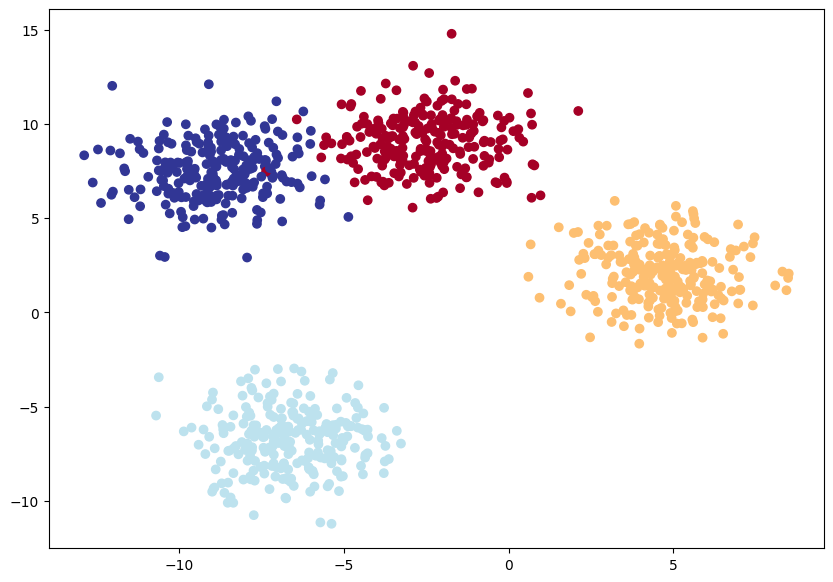

In [ ]:
# Visualize

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

Data seems linearly separable, theres no need of non-linearity; however, even if we use it, its no harm

In [ ]:
# Model Building

from torch import nn

class MultiClassClassification(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(), # Optional for linearly separable data
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(), # Optional for linearly separable data
        nn.Linear(in_features=hidden_units, out_features=output_features)
        )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [ ]:
model = MultiClassClassification(2, 4, 8)
model.to(device)
model

MultiClassClassification(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
torch.unique(y_train)

tensor([0, 1, 2, 3])

In [ ]:
# Loss Function, Optimizer and Accuracy Function

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.1)
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # .item() because one number is needed
  acc = (correct/len(y_pred)) * 100
  return acc

In [ ]:
model.eval()
with torch.inference_mode():
  y_logits = model(X_test) # Logits
  y_pred_probs = torch.softmax(y_logits, dim=1) # Prediction probabilities
  y_pred = torch.argmax(y_pred_probs, dim=1) # Find the most probable class

print(torch.sum(y_pred_probs[0])) # Should be 1
y_logits[:5], y_pred_probs[:5], y_pred[:5], y_train[:5]

tensor(1.)


(tensor([[ 0.0523, -0.1514, -0.0675,  0.3170],
         [-0.4016,  0.2710, -0.1802,  0.3549],
         [-0.7251, -0.2804, -0.7581, -0.9764],
         [ 0.0713, -0.2249, -0.1094,  0.2996],
         [ 0.1098, -0.1257, -0.0044,  0.3208]]),
 tensor([[0.2496, 0.2036, 0.2215, 0.3253],
         [0.1578, 0.3091, 0.1969, 0.3362],
         [0.2323, 0.3623, 0.2247, 0.1807],
         [0.2608, 0.1939, 0.2177, 0.3277],
         [0.2553, 0.2017, 0.2277, 0.3153]]),
 tensor([3, 3, 1, 3, 3]),
 tensor([1, 0, 2, 2, 0]))

In [ ]:
# Training Loop

torch.manual_seed(RANDOM_SEED)
epochs = 100

for epoch in range(epochs):
  # Training
  model.train()

  y_logits = model(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train, y_pred = y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.40229, Acc: 12.38% | Test Loss: 1.17150, Test Acc: 55.00%
Epoch: 10 | Loss: 0.65563, Acc: 71.50% | Test Loss: 0.54812, Test Acc: 77.50%
Epoch: 20 | Loss: 0.45196, Acc: 89.62% | Test Loss: 0.36566, Test Acc: 92.50%
Epoch: 30 | Loss: 0.28065, Acc: 98.12% | Test Loss: 0.21169, Test Acc: 98.50%
Epoch: 40 | Loss: 0.12256, Acc: 98.88% | Test Loss: 0.09358, Test Acc: 99.50%
Epoch: 50 | Loss: 0.07726, Acc: 98.75% | Test Loss: 0.05967, Test Acc: 99.50%
Epoch: 60 | Loss: 0.06034, Acc: 98.75% | Test Loss: 0.04629, Test Acc: 99.50%
Epoch: 70 | Loss: 0.05177, Acc: 98.88% | Test Loss: 0.03939, Test Acc: 99.50%
Epoch: 80 | Loss: 0.04667, Acc: 98.88% | Test Loss: 0.03514, Test Acc: 99.50%
Epoch: 90 | Loss: 0.04332, Acc: 99.00% | Test Loss: 0.03224, Test Acc: 99.50%


In [ ]:
import requests
from pathlib import Path
print("Downloading helper_functions.py")
request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
with open("helper_functions.py", "wb") as f:
  f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

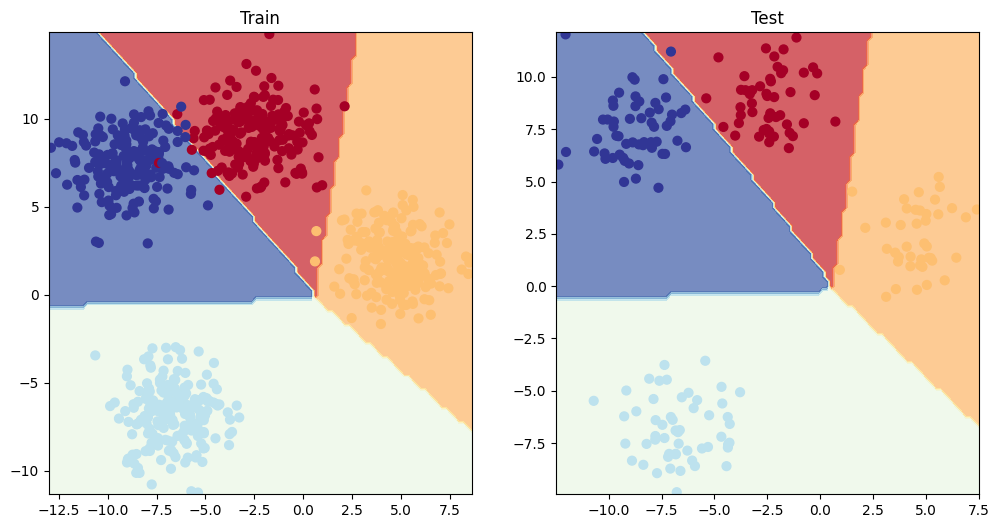

In [ ]:
# Visualize Results

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

## Classification Metrics

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`torchmetrics.Accuracy()`](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html#id3) or [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`torchmetrics.Precision()`](https://torchmetrics.readthedocs.io/en/stable/classification/precision.html#id4) or [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`torchmetrics.Recall()`](https://torchmetrics.readthedocs.io/en/stable/classification/recall.html#id5) or [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`torchmetrics.F1Score()`](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html#f1score) or [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| Confusion matrix| Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html#confusionmatrix) or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |


torchmetrics helps use torch like code to evalueate performance

In [ ]:
# !pip install torchmetrics
# from torchmetrics import Accuracy

# torchmetrics_accuracy = Accuracy().to(device)
# torchmetrics_accuracy(y_pred, y_test)